1. Хочу посмотреть, какие признаки вообще есть

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df = pd.read_csv('train.csv')

from tabulate import tabulate
print(tabulate([(col, dtype) for col, dtype in zip(df.columns, df.dtypes)],
               headers=['Признак', 'Тип данных'], tablefmt='grid'))

+----------------------------+--------------+
| Признак                    | Тип данных   |
+============================+==============+
| ApplicationDate            | object       |
+----------------------------+--------------+
| Age                        | float64      |
+----------------------------+--------------+
| AnnualIncome               | float64      |
+----------------------------+--------------+
| CreditScore                | float64      |
+----------------------------+--------------+
| LoanAmount                 | float64      |
+----------------------------+--------------+
| LoanDuration               | float64      |
+----------------------------+--------------+
| MaritalStatus              | object       |
+----------------------------+--------------+
| NumberOfDependents         | float64      |
+----------------------------+--------------+
| HomeOwnershipStatus        | object       |
+----------------------------+--------------+
| MonthlyDebtPayments        | flo

2. Удалю все строки где есть NULL-value и проведу анализ выбросов целевой переменной

В данных больше нет null значений
RiskScore
-9.999999e+06    115
 1.000000e+07     84
 3.704447e+01      3
 5.967628e+01      3
 6.785041e+01      3
                ... 
 4.093270e+01      1
 3.174699e+01      1
 7.617149e+01      1
 4.058056e+01      1
 5.137230e+01      1
Name: count, Length: 9334, dtype: int64


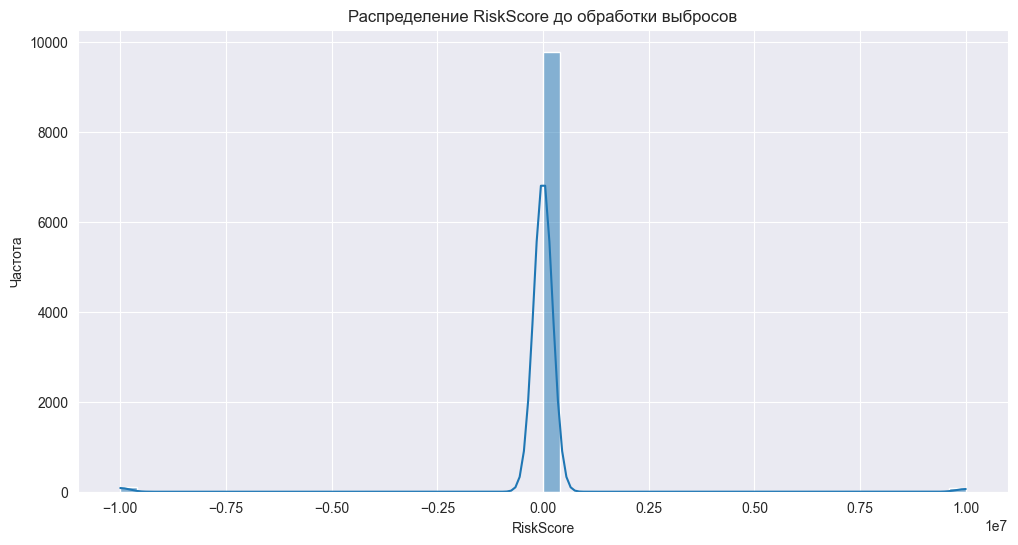

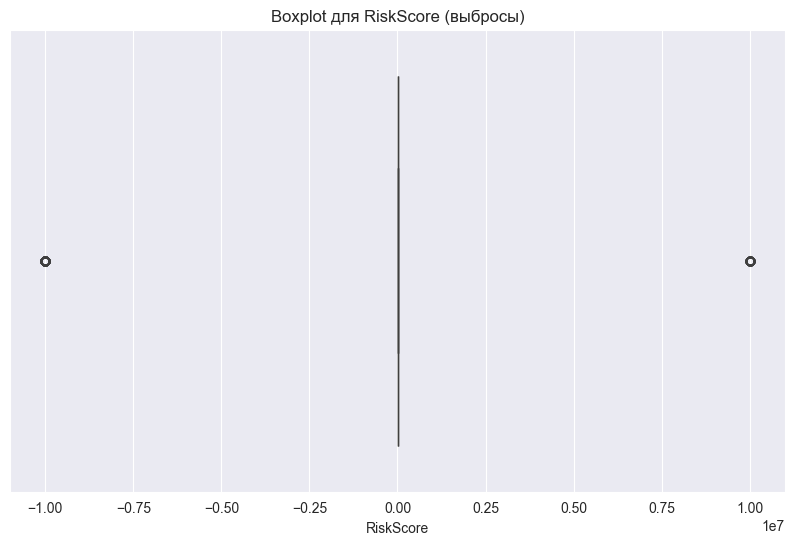


Границы выбросов (метод IQR):
Нижняя граница: -16.71
Верхняя граница: 114.55

Количество выбросов: 199 (1.99%)


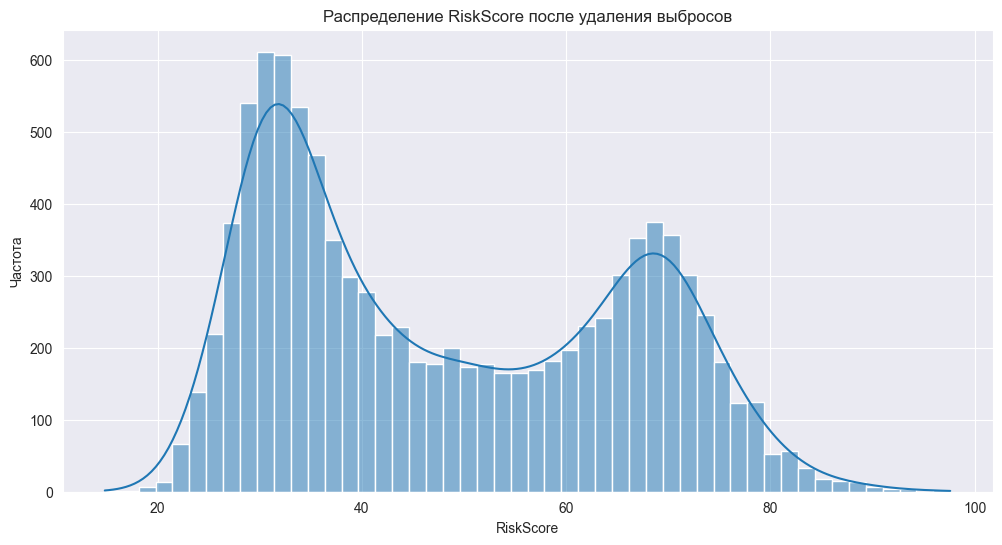

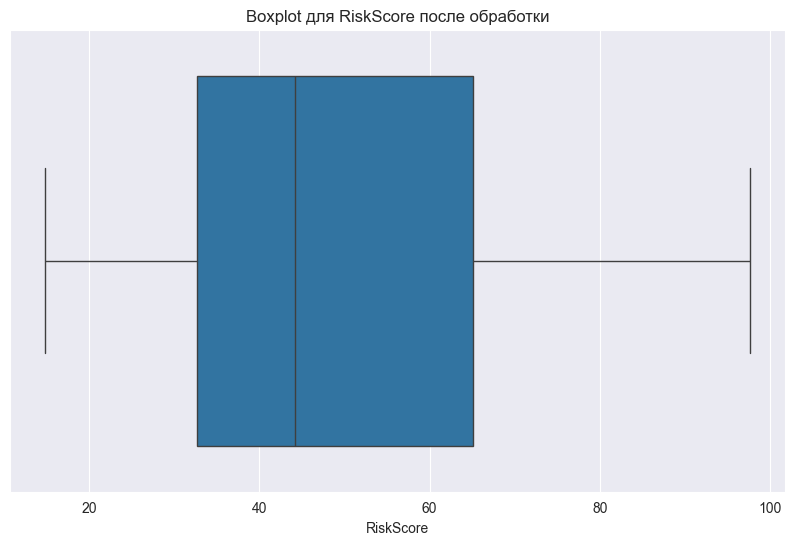


Сравнение статистик до и после:
До обработки:
count    9.986000e+03
mean    -3.099606e+04
std      1.411392e+06
min     -9.999999e+06
25%      3.251016e+01
50%      4.406128e+01
75%      6.532677e+01
max      1.000000e+07
Name: RiskScore, dtype: float64

После обработки:
count    9787.000000
mean       48.349800
std        17.255990
min        14.841417
25%        32.699940
50%        44.151002
75%        65.122034
max        97.597249
Name: RiskScore, dtype: float64


In [59]:
df_cleaned = df.dropna()
if df_cleaned.isnull().sum().sum() == 0:
    print("В данных больше нет null значений")
else:
    print("Обнаружены null значения")


target_col = "RiskScore"
print(df_cleaned[target_col].value_counts())

plt.figure(figsize=(12, 6))
sns.histplot(df_cleaned[target_col], bins=50, kde=True)
plt.title('Распределение RiskScore до обработки выбросов')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x=df_cleaned[target_col])
plt.title('Boxplot для RiskScore (выбросы)')
plt.show()

Q1 = df_cleaned[target_col].quantile(0.25)
Q3 = df_cleaned[target_col].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"\nГраницы выбросов (метод IQR):")
print(f"Нижняя граница: {lower_bound:.2f}")
print(f"Верхняя граница: {upper_bound:.2f}")


outliers = df_cleaned[(df_cleaned[target_col] < lower_bound) | (df_cleaned[target_col] > upper_bound)]
print(f"\nКоличество выбросов: {len(outliers)} ({len(outliers)/len(df_cleaned)*100:.2f}%)")

df_ = df_cleaned[(df_cleaned[target_col] >= lower_bound) &
                           (df_cleaned[target_col] <= upper_bound)].copy()


plt.figure(figsize=(12, 6))
sns.histplot(df_[target_col], bins=50, kde=True)
plt.title('Распределение RiskScore после удаления выбросов')
plt.xlabel('RiskScore')
plt.ylabel('Частота')
plt.show()


plt.figure(figsize=(10, 6))
sns.boxplot(x=df_[target_col])
plt.title('Boxplot для RiskScore после обработки')
plt.show()

print("\nСравнение статистик до и после:")
print("До обработки:")
print(df_cleaned[target_col].describe())
print("\nПосле обработки:")
print(df_[target_col].describe())

3. Посмотрим на типы признаков (их примерный состав)


In [60]:

numeric_cols = df_.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("\nЧисловые признаки (%d):" % len(numeric_cols))
print(numeric_cols)

categorical_cols = df_.select_dtypes(include=['object', 'bool', 'category']).columns.tolist()
print("\nКатегориальные признаки (%d):" % len(categorical_cols))
print(categorical_cols)

datetime_cols = df_.select_dtypes(include=['datetime64', 'timedelta64']).columns.tolist()
if datetime_cols:
    print("\nДата/время признаки (%d):" % len(datetime_cols))
    print(datetime_cols)


Числовые признаки (30):
['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount', 'LoanDuration', 'NumberOfDependents', 'MonthlyDebtPayments', 'CreditCardUtilizationRate', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'DebtToIncomeRatio', 'BankruptcyHistory', 'PreviousLoanDefaults', 'PaymentHistory', 'LengthOfCreditHistory', 'SavingsAccountBalance', 'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 'MonthlyIncome', 'UtilityBillsPaymentHistory', 'JobTenure', 'Experience', 'NetWorth', 'BaseInterestRate', 'InterestRate', 'MonthlyLoanPayment', 'TotalDebtToIncomeRatio', 'LoanApproved', 'RiskScore']

Категориальные признаки (6):
['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']


4. Посмотрим на псевдо-числовые признаки

In [61]:
pseudo_numeric = []
for col in numeric_cols:
    if df_[col].nunique() < 15:
        pseudo_numeric.append(col)

if pseudo_numeric:
    print("\nВозможные псевдо-числовые признаки (мало уникальных значений):")
    print(pseudo_numeric)

    for col in pseudo_numeric:
        print(f"\nРаспределение для {col}:")
        print(df_[col].value_counts().sort_index())


Возможные псевдо-числовые признаки (мало уникальных значений):
['LoanDuration', 'NumberOfDependents', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'LoanApproved']

Распределение для LoanDuration:
LoanDuration
12.0      483
24.0      963
36.0     2040
48.0     1955
60.0     1992
72.0      908
84.0      470
96.0      492
108.0     239
120.0     245
Name: count, dtype: int64

Распределение для NumberOfDependents:
NumberOfDependents
0.0    2852
1.0    2394
2.0    2061
3.0    1472
4.0     722
5.0     183
6.0     103
Name: count, dtype: int64

Распределение для NumberOfOpenCreditLines:
NumberOfOpenCreditLines
0.0      465
1.0     1435
2.0     2201
3.0     2150
4.0     1688
5.0     1015
6.0      480
7.0      217
8.0       98
9.0       27
10.0      10
12.0       1
Name: count, dtype: int64

Распределение для NumberOfCreditInquiries:
NumberOfCreditInquiries
0.0    3696
1.0    3578
2.0    1754
3.0     592
4.0     141
5.0      23
6.0       3


5. Значит в первую очередь будем обрабатывать (пытаться перевести в ноормальные числовые признаки) категориальные признаки: ['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'] и псевдо-числовые признаки: ['LoanDuration', 'NumberOfDependents', 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries', 'BankruptcyHistory', 'PreviousLoanDefaults', 'LoanApproved']

6. Попробуем визуализировать корреляцию чисто числовых признаков и целевой переменной

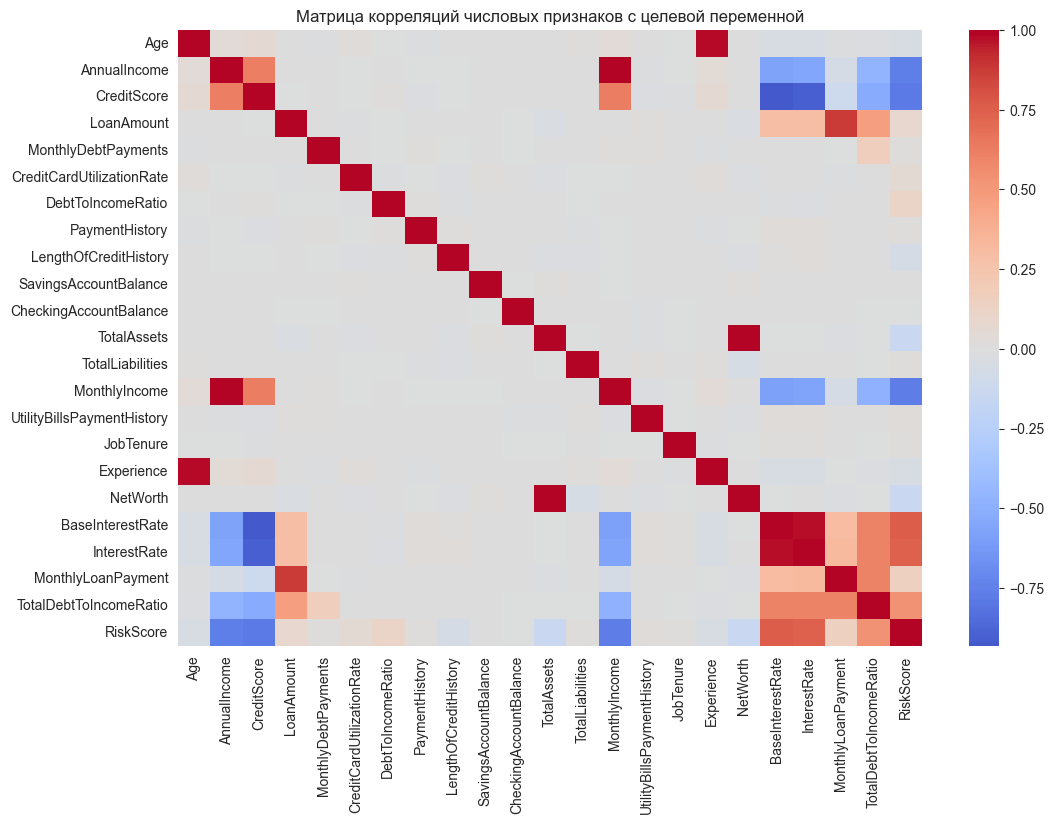

In [62]:
cat_features = categorical_cols + pseudo_numeric

numerical_cols = df_.select_dtypes(include=['int64', 'float64']).columns
numerical_cols = [col for col in numerical_cols if col not in pseudo_numeric and col != target_col]

plt.figure(figsize=(12, 8))
sns.heatmap(df_[numerical_cols + [target_col]].corr(), cmap='coolwarm', center=0)
plt.title('Матрица корреляций числовых признаков с целевой переменной')
plt.show()

# тут попробовал вывести корреляцию с категориальными признаками - ничего не вышло, что логично

7. Выведем парные зависимости для первых 5 числовых признаков

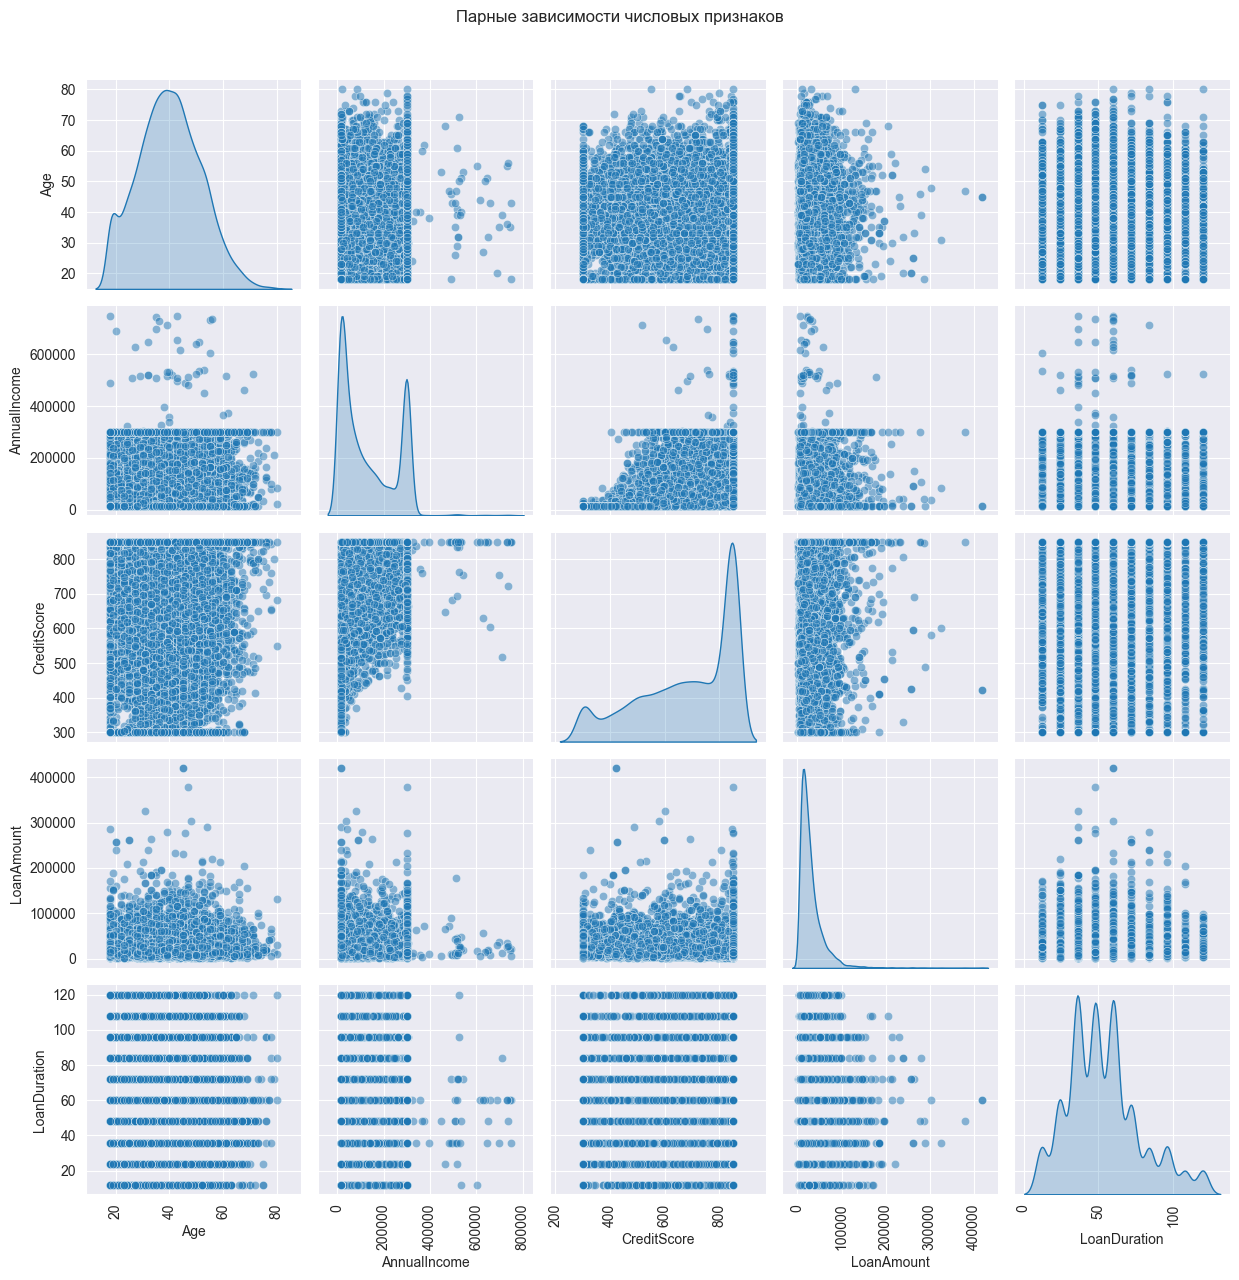

In [63]:
num_cols = df_.select_dtypes(include=['float64', 'int64']).columns[:5]

g = sns.pairplot(df_[num_cols], diag_kind='kde', plot_kws={'alpha': 0.5})
plt.suptitle('Парные зависимости числовых признаков', y=1.02)

for ax in g.axes.flat:
    if ax.get_xlabel():
        ax.tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

8. Теперь будем разделять категориальные признаки на числовые или бинарные

In [64]:
print(categorical_cols)

print(df_.shape[1])  # Выведет число столбцов


df_['ApplicationDate'] = pd.to_datetime(df_['ApplicationDate'])
df_['Year'] = df_['ApplicationDate'].dt.year
df_['Month'] = df_['ApplicationDate'].dt.month
df_['Day'] = df_['ApplicationDate'].dt.day
df_['DayOfWeek'] = df_['ApplicationDate'].dt.dayofweek  # 0-понедельник, 6-воскресенье
df_['DayOfYear'] = df_['ApplicationDate'].dt.dayofyear

print(df_.shape[1])

#df_ = df_.drop('ApplicationDate', axis=1)

print(df_.shape[1])

print(df_[['Year', 'Month', 'Day', 'DayOfWeek', 'DayOfYear']].head())


unique_values = df_['MaritalStatus'].unique()
print(f"Уникальные значения: {unique_values}")
print(f"Количество уникальных значений: {len(unique_values)}")

['ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel']
36
41
41
   Year  Month  Day  DayOfWeek  DayOfYear
0  2010      6   26          5        177
1  1996      9   23          0        267
2  2015      1   19          0         19
3  1981      5   12          1        132
4  1995      5    7          6        127
Уникальные значения: ['Divorced' 'Widowed' 'Married' 'Single']
Количество уникальных значений: 4
